In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4506669.95it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134089.40it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1089904.92it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5300647.96it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

60000
10000


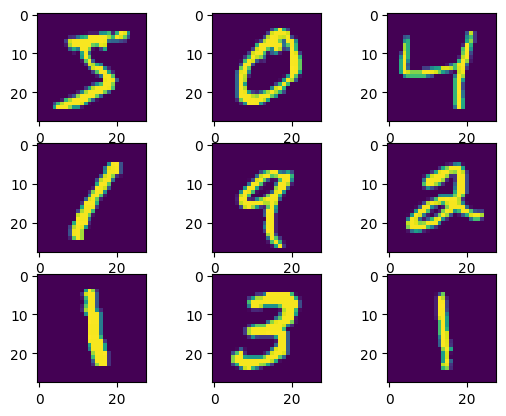

In [ ]:
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

training_data = MNIST(root="./", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./", train=False, download=True, transform=ToTensor())

print(len(training_data))
print(len(test_data))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(training_data.data[i])
plt.show()

In [ ]:
from torch.utils.data.dataloader import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()

        # 합성곱층 정의하기
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)

        # 배치 정규화층 정의
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 활성화 함수 정의
        self.relu = nn.ReLU()

        # 다운샘플 정의
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x_ = x

        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.c2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            x_ = self.downsample(x_)

        x += x_
        x = self.relu(x)
        return x

# ResNet 모델 정의
class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()

        self.b1 = block(in_channels=1, out_channels=64)
        self.b2 = block(in_channels=64, out_channels=128)
        self.b3 = block(in_channels=128, out_channels=256)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # MNIST 이미지 크기(28x28)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)
        x = self.pool(x)
        x = self.b3(x)
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)

ResNet(
  (b1): BasicBlock(
    (c1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (downsample): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
from torch.optim import Adam
from tqdm import tqdm

lr = 1e-4
optim= Adam(model.parameters(), lr=lr)

for epoch in range(10):
  iterator = tqdm(train_dataloader)
  for data, label in iterator:
    optim.zero_grad()

    preds = model(data.to(device))

    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()

    iterator.set_description(f"epoch: {epoch+1} loss: {loss.item():.8f}")

torch.save(model.state_dict(), "ResNet.pth")

epoch: 30 loss: 0.00000004: 100%|██████████| 1875/1875 [00:30<00:00, 61.09it/s]


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total predictions
correct = 0
total = 0

# Disable gradient calculations
with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)

        # Get predictions
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')ㅌ

Test Accuracy: 99.62%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋에 맞춘 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

training_data = CIFAR10(root="./", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# BasicBlock 및 ResNet 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x_ = x
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            x_ = self.downsample(x_)
        x += x_
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.b1 = block(in_channels=3, out_channels=64)  # CIFAR-10 이미지는 3 채널(RGB)
        self.b2 = block(in_channels=64, out_channels=128)
        self.b3 = block(in_channels=128, out_channels=256)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # CIFAR-10 이미지 크기(32x32)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)
        x = self.pool(x)
        x = self.b3(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# 학습 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 학습 루프
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/15, Loss: 1.212619682178473
Epoch 2/15, Loss: 0.7075678982088328
Epoch 3/15, Loss: 0.5051305612068042
Epoch 4/15, Loss: 0.3685993504760515
Epoch 5/15, Loss: 0.26080789521831993
Epoch 6/15, Loss: 0.1732452024022103
Epoch 7/15, Loss: 0.11347148327104499
Epoch 8/15, Loss: 0.08288532110583752
Epoch 9/15, Loss: 0.0631540667728933
Epoch 10/15, Loss: 0.057868304102362406
Epoch 11/15, Loss: 0.04792755713958479
Epoch 12/15, Loss: 0.04770421342509787
Epoch 13/15, Loss: 0.03469900202470274
Epoch 14/15, Loss: 0.0334559611505275
Epoch 15/15, Loss: 0.03997258219720267


In [ ]:
# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 84.01%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋에 맞춘 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

training_data = CIFAR10(root="./", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# BasicBlock 및 ResNet 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x_ = x
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            x_ = self.downsample(x_)
        x += x_
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.b1 = block(in_channels=3, out_channels=64)  # CIFAR-10 이미지는 3 채널(RGB)
        self.b2 = block(in_channels=64, out_channels=128)
        self.b3 = block(in_channels=128, out_channels=256)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # CIFAR-10 이미지 크기(32x32)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)
        x = self.pool(x)
        x = self.b3(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 학습 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 스케줄러 초기화

# 학습 루프
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 학습률 업데이트
    scheduler.step()

    # 현재 학습률 출력
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Learning Rate: {current_lr}")

# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

100%|██████████| 170498071/170498071 [00:03<00:00, 42912174.22it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Epoch 1/15, Loss: 1.3922769870904401, Learning Rate: 0.001
Epoch 2/15, Loss: 0.9084739969362079, Learning Rate: 0.001
Epoch 3/15, Loss: 0.7043208841548856, Learning Rate: 0.001
Epoch 4/15, Loss: 0.5824587398096729, Learning Rate: 0.001
Epoch 5/15, Loss: 0.4964034835929456, Learning Rate: 0.001
Epoch 6/15, Loss: 0.4371373100239602, Learning Rate: 0.001
Epoch 7/15, Loss: 0.3926087353292786, Learning Rate: 0.001
Epoch 8/15, Loss: 0.3506616155433533, Learning Rate: 0.001
Epoch 9/15, Loss: 0.31320518678259057, Learning Rate: 0.001
Epoch 10/15, Loss: 0.2870209834936177, Learning Rate: 0.0001
Epoch 11/15, Loss: 0.19574125575573395, Learning Rate: 0.0001
Epoch 12/15, Loss: 0.1658977996772322, Learning Rate: 0.0001
Epoch 13/15, Loss: 0.1526244363254484, Learning Rate: 0.0001
Epoch 14/15, Loss: 0.1430547961684139, Learning Rate: 0.0001
Epoch 15/15, Loss: 0.13422542554624092, Learning Rate: 0.0001
Accuracy of the mode

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋에 맞춘 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

training_data = CIFAR10(root="./", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# BasicBlock 및 ResNet 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x_ = x
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            x_ = self.downsample(x_)
        x += x_
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.b1 = block(in_channels=3, out_channels=64)  # CIFAR-10 이미지는 3 채널(RGB)
        self.b2 = block(in_channels=64, out_channels=128)  # 레이어 2에 추가된 블록
        self.b3 = block(in_channels=128, out_channels=128)  # 레이어 2에 추가된 블록
        self.b4 = block(in_channels=128, out_channels=256)  # 레이어 3에 추가된 블록
        self.b5 = block(in_channels=256, out_channels=256)  # 레이어 3에 추가된 블록
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # CIFAR-10 이미지 크기(32x32)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)  # 레이어 2에서 추가된 블록
        x = self.b3(x)  # 레이어 2에서 추가된 블록
        x = self.pool(x)
        x = self.b4(x)  # 레이어 3에서 추가된 블록
        x = self.b5(x)  # 레이어 3에서 추가된 블록
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 학습 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 스케줄러 초기화

# 학습 루프
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 학습률 업데이트
    scheduler.step()

    # 현재 학습률 출력
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Learning Rate: {current_lr}")

# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Loss: 1.5558335701827808, Learning Rate: 0.001
Epoch 2/15, Loss: 1.1001707856612437, Learning Rate: 0.001
Epoch 3/15, Loss: 0.8886599015930424, Learning Rate: 0.001
Epoch 4/15, Loss: 0.7483946900919575, Learning Rate: 0.001
Epoch 5/15, Loss: 0.6532728075600036, Learning Rate: 0.001
Epoch 6/15, Loss: 0.5657970766963252, Learning Rate: 0.001
Epoch 7/15, Loss: 0.5092005751207661, Learning Rate: 0.001
Epoch 8/15, Loss: 0.45165437301787575, Learning Rate: 0.001
Epoch 9/15, Loss: 0.41626235697885305, Learning Rate: 0.001
Epoch 10/15, Loss: 0.38470886330432297, Learning Rate: 0.0001
Epoch 11/15, Loss: 0.26826154927501594, Learning Rate: 0.0001
Epoch 12/15, Loss: 0.23885303263164237, Learning Rate: 0.0001
Epoch 13/15, Loss: 0.226880258068328, Learning Rate: 0.0001
Epoch 14/15, Loss: 0.21356941322746026, Learning Rate: 0.0001
Epoch 15/15, Loss: 0.2055493156375635, Learning Rate: 0.0001
Accuracy of the model 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# CIFAR-10 데이터셋에 맞춘 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

training_data = CIFAR10(root="./", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# BasicBlock 및 ResNet 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # 배치 정규화 추가
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 배치 정규화 추가
        self.relu = nn.ReLU()
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            self.bn_downsample = nn.BatchNorm2d(out_channels)  # 배치 정규화 추가

    def forward(self, x):
        x_ = x
        x = self.c1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        if self.downsample is not None:
            x_ = self.downsample(x_)
            x_ = self.bn_downsample(x_)  # 배치 정규화 적용
        x += x_
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.b1 = block(in_channels=3, out_channels=64)  # CIFAR-10 이미지는 3 채널(RGB)
        self.b2 = block(in_channels=64, out_channels=128)  # 레이어 2에 추가된 블록
        self.b3 = block(in_channels=128, out_channels=128)  # 레이어 2에 추가된 블록
        self.b4 = block(in_channels=128, out_channels=256)  # 레이어 3에 추가된 블록
        self.b5 = block(in_channels=256, out_channels=256)  # 레이어 3에 추가된 블록
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # CIFAR-10 이미지 크기(32x32)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)  # 레이어 2에서 추가된 블록
        x = self.b3(x)  # 레이어 2에서 추가된 블록
        x = self.pool(x)
        x = self.b4(x)  # 레이어 3에서 추가된 블록
        x = self.b5(x)  # 레이어 3에서 추가된 블록
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 학습 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 스케줄러 초기화

# 학습 루프
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 학습률 업데이트
    scheduler.step()

    # 현재 학습률 출력
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Learning Rate: {current_lr}")

# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Loss: 1.4992169061737597, Learning Rate: 0.001
Epoch 2/15, Loss: 1.0576794568230123, Learning Rate: 0.001
Epoch 3/15, Loss: 0.84558966755867, Learning Rate: 0.001
Epoch 4/15, Loss: 0.7044079229807305, Learning Rate: 0.001
Epoch 5/15, Loss: 0.6011244706104478, Learning Rate: 0.001
Epoch 6/15, Loss: 0.5197887662655253, Learning Rate: 0.001
Epoch 7/15, Loss: 0.4639984415582074, Learning Rate: 0.001
Epoch 8/15, Loss: 0.4113897891605602, Learning Rate: 0.001
Epoch 9/15, Loss: 0.3774785412489758, Learning Rate: 0.001
Epoch 10/15, Loss: 0.34278856063514107, Learning Rate: 0.0001
Epoch 11/15, Loss: 0.23151218786340236, Learning Rate: 0.0001
Epoch 12/15, Loss: 0.20079057027235667, Learning Rate: 0.0001
Epoch 13/15, Loss: 0.1869887159732373, Learning Rate: 0.0001
Epoch 14/15, Loss: 0.17438305009994895, Learning Rate: 0.0001
Epoch 15/15, Loss: 0.16958364128085124, Learning Rate: 0.0001
Accuracy of the model on

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split

# CIFAR-10 데이터셋에 맞춘 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

training_data = CIFAR10(root="./", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

# 검증 세트를 위해 데이터 분할
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
train_data, val_data = random_split(training_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# BasicBlock 및 ResNet 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # 배치 정규화 추가
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 배치 정규화 추가
        self.relu = nn.ReLU()
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            self.bn_downsample = nn.BatchNorm2d(out_channels)  # 배치 정규화 추가

    def forward(self, x):
        x_ = x
        x = self.c1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        if self.downsample is not None:
            x_ = self.downsample(x_)
            x_ = self.bn_downsample(x_)  # 배치 정규화 적용
        x += x_
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.b1 = block(in_channels=3, out_channels=64)  # CIFAR-10 이미지는 3 채널(RGB)
        self.b2 = block(in_channels=64, out_channels=128)  # 레이어 2에 추가된 블록
        self.b3 = block(in_channels=128, out_channels=128)  # 레이어 2에 추가된 블록
        self.b4 = block(in_channels=128, out_channels=256)  # 레이어 3에 추가된 블록
        self.b5 = block(in_channels=256, out_channels=256)  # 레이어 3에 추가된 블록
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # CIFAR-10 이미지 크기(32x32)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)  # 레이어 2에서 추가된 블록
        x = self.b3(x)  # 레이어 2에서 추가된 블록
        x = self.pool(x)
        x = self.b4(x)  # 레이어 3에서 추가된 블록
        x = self.b5(x)  # 레이어 3에서 추가된 블록
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 학습 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 스케줄러 초기화

epochs = 50
early_stopping_patience = 5  # 조기 종료를 위한 patience 설정
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 학습률 업데이트
    scheduler.step()

    # 현재 학습률 출력
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Learning Rate: {current_lr}")

    # 검증 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # 조기 종료 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stop")
            break

# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Data Set 에 대한 정확도 : {100 * correct / total}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Loss: 1.58576313495636, Learning Rate: 0.001
Validation Loss: 1.3181641568803484
Epoch 2/50, Loss: 1.1296372283935547, Learning Rate: 0.001
Validation Loss: 1.1049794774905892
Epoch 3/50, Loss: 0.920072786808014, Learning Rate: 0.001
Validation Loss: 0.9043255987440705
Epoch 4/50, Loss: 0.7892932816505432, Learning Rate: 0.001
Validation Loss: 0.7796495300569352
Epoch 5/50, Loss: 0.6831730722427368, Learning Rate: 0.001
Validation Loss: 0.7220542996552339
Epoch 6/50, Loss: 0.5999268781661987, Learning Rate: 0.001
Validation Loss: 0.6284308739148887
Epoch 7/50, Loss: 0.5286332146167755, Learning Rate: 0.001
Validation Loss: 0.666615941911746
Epoch 8/50, Loss: 0.4825626493930817, Learning Rate: 0.001
Validation Loss: 0.6219275234990819
Epoch 9/50, Loss: 0.435556382060051, Learning Rate: 0.001
Validation Loss: 0.5400873728238853
Epoch 10/50, Loss: 0.39946982429027555, Learning Rate: 0.0001
Validation L

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset

# CIFAR-10 데이터셋에 맞춘 데이터 전처리 및 로드
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to [-1, 1]
])

training_data = CIFAR10(root="./", train=True, download=True, transform=transform)

# 데이터를 훈련용과 검증용으로 나누기
train_ratio = 0.8
train_size = int(train_ratio * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])

test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# BasicBlock 및 ResNet 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x_ = x
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.c2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            x_ = self.downsample(x_)
        x += x_
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.b1 = block(in_channels=3, out_channels=64)  # CIFAR-10 이미지는 3 채널(RGB)
        self.b2 = block(in_channels=64, out_channels=128)
        self.b3 = block(in_channels=128, out_channels=256)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # CIFAR-10 이미지 크기(32x32)에 따라 수정 필요
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.b1(x)
        x = self.pool(x)
        x = self.b2(x)
        x = self.pool(x)
        x = self.b3(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 학습 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(block=BasicBlock)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 스케줄러 초기화

# Early Stopping 관련 변수 초기화
early_stop_patience = 5  # 최소한 early stopping을 위한 patience 설정
best_val_loss = float('inf')
patience_counter = 0

# 학습 루프
epochs = 50  # 에폭 수 설정

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 학습률 업데이트
    scheduler.step()

    # 현재 학습률 출력
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{epochs}, \n Loss: {running_loss/len(train_loader)}, \n Learning Rate: {current_lr}")

    # 검증 데이터로 평가
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"검증 loss 값 : {val_loss}")  # 검증 데이터의 손실 출력

    # Early stopping 조건 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping")
            break

# 최종 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n 정확도 : {100 * correct / total}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, 
 Loss: 1.4161937278747558, 
 Learning Rate: 0.001
검증 loss 값 : 1.141877902541191
Epoch 2/50, 
 Loss: 0.9813860609054565, 
 Learning Rate: 0.001
검증 loss 값 : 0.9116458627069073
Epoch 3/50, 
 Loss: 0.7732632119655609, 
 Learning Rate: 0.001
검증 loss 값 : 0.7430894031266498
Epoch 4/50, 
 Loss: 0.6379138450145722, 
 Learning Rate: 0.001
검증 loss 값 : 0.6279040893931298
Epoch 5/50, 
 Loss: 0.5416614319801331, 
 Learning Rate: 0.001
검증 loss 값 : 0.6218080256774927
Epoch 6/50, 
 Loss: 0.48078493552207946, 
 Learning Rate: 0.001
검증 loss 값 : 0.5712955138485902
Epoch 7/50, 
 Loss: 0.43017313640117644, 
 Learning Rate: 0.001
검증 loss 값 : 0.5432967386048311
Epoch 8/50, 
 Loss: 0.383597461605072, 
 Learning Rate: 0.001
검증 loss 값 : 0.49837368859606945
Epoch 9/50, 
 Loss: 0.34426924291849137, 
 Learning Rate: 0.001
검증 loss 값 : 0.4938453763343726
Epoch 10/50, 
 Loss: 0.3221910993218422, 
 Learning Rate: 0.0001
검증 loss 값 :